In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
import mlflow

In [2]:
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

In [3]:
def underline_second_largest(s):
    is_second_largest = s == s.nlargest(2).iloc[-1]
    return ['text-decoration: underline' if v else '' for v in is_second_largest]

In [4]:
def style_largest_and_second(s):
    styles = ['' for _ in s]  # Initialize empty styles
    if len(s) >= 2:
        max_val = s.nlargest(1).iloc[0]  # Find the largest
        second_max_val = s.nlargest(2).iloc[-1]  # Find the second largest
        styles = ['font-weight: bold' if v == max_val else
                  'text-decoration: underline' if v == second_max_val else ''
                  for v in s]
    return styles

In [5]:
def get_experiment_df(experiment_name):
    client = MlflowClient()
    exp_id = client.get_experiment_by_name(experiment_name)

    if exp_id is None:
        return None
    runs_df = mlflow.search_runs(experiment_ids=[exp_id.experiment_id])

    runs_df.columns = [re.sub("params.", "", col) for col in runs_df.columns]
    runs_df.columns = [re.sub("metrics.", "", col) for col in runs_df.columns]
    
    
    return runs_df

## RESULTS FOR 50% OF POOL DATA

In [6]:
mlflow.search_experiments()

[<Experiment: artifact_location='file:///scratch/potter.mi/LogisticALBenchmark/mlruns/130678960536778169', creation_time=1725974872072, experiment_id='130678960536778169', last_update_time=1725974872072, lifecycle_stage='active', name='AL_large_paper', tags={}>,
 <Experiment: artifact_location='file:///scratch/potter.mi/LogisticALBenchmark/mlruns/474241495440491713', creation_time=1725587750819, experiment_id='474241495440491713', last_update_time=1725587750819, lifecycle_stage='active', name='AL_fixed', tags={}>,
 <Experiment: artifact_location='file:///scratch/potter.mi/LogisticALBenchmark/mlruns/688328213376658147', creation_time=1725533750786, experiment_id='688328213376658147', last_update_time=1725533750786, lifecycle_stage='active', name='AL_reproducibility_small', tags={}>,
 <Experiment: artifact_location='file:///scratch/potter.mi/LogisticALBenchmark/mlruns/767125422517401034', creation_time=1725509109867, experiment_id='767125422517401034', last_update_time=1725509109867, lif

In [7]:
experiment_name = "AL_large_paper"

In [8]:
mlflow_df = get_experiment_df(experiment_name)

In [9]:
coi = ['alc_test','accuracy_baseline','accuracy_test','dataset','query_method_name']
mlflow_df = mlflow_df[coi]

In [10]:
# Step 1: Create a dictionary with random 'alc_test' values for each dataset
random_alc_values = mlflow_df[mlflow_df['query_method_name'] == 'random'].set_index('dataset')['alc_test'].to_dict()

# Step 2: Divide each 'alc_test' by the corresponding 'random' value for each dataset
def divide_by_random(row):
    dataset = row['dataset']
    if dataset in random_alc_values:
        random_value = random_alc_values[dataset]
        if pd.notna(random_value) and pd.notna(row['alc_test']):  # Avoid division by NaN
            return row['alc_test'] / random_value
    return None  # For NaN or missing datasets

# Apply the function to create a new column with the divided values
mlflow_df['alc_ratio'] = mlflow_df.apply(divide_by_random, axis=1)

In [11]:
mlflow_df.isna().values.any(axis=-1).sum()

2

In [12]:
mlflow_df[mlflow_df[['dataset','query_method_name','alc_test']].duplicated()]

,alc_test,accuracy_baseline,accuracy_test,dataset,query_method_name,alc_ratio
46,NaN,NaN,NaN,None,None,NaN


In [13]:
alc_df = mlflow_df.pivot_table(index='dataset', columns='query_method_name', values='alc_test', aggfunc='mean')
alc_df = alc_df.reindex(columns=['random','entropy', 'error_reduction', 'max_error_reduction','fivr','max_model_change'])
alc_df.style.apply(style_largest_and_second, axis=1)

query_method_name,random,entropy,error_reduction,max_error_reduction,fivr,max_model_change
dataset,,,,,,
acute,0.970301,0.991622,0.971166,0.958289,0.991888,0.991711
breast_cancer,0.948665,0.959362,0.956720,0.963689,0.960815,0.959939
diabetes,0.740397,0.732617,0.738006,0.727274,0.748418,0.727148
haberman,0.727129,0.709937,0.716059,0.710071,0.729745,0.703946
heart_disease,0.767619,0.804452,0.798174,0.787924,0.799390,0.803924
ionosphere,0.835470,0.850656,0.854750,0.847834,0.860918,0.787256
parkinsons,0.772952,0.828538,0.805028,0.821429,0.829387,0.836896
planning,0.583812,0.593605,0.598487,0.594537,0.586077,0.604225
sonar,0.708312,0.725573,0.722517,0.721646,0.733566,0.711288


In [14]:
acc_df = mlflow_df.pivot_table(index='dataset', columns='query_method_name', values='accuracy_test', aggfunc='mean')
acc_df = alc_df.reindex(columns=['random','entropy', 'error_reduction', 'max_error_reduction','fivr','max_model_change'])
acc_df.style.apply(style_largest_and_second, axis=1)

query_method_name,random,entropy,error_reduction,max_error_reduction,fivr,max_model_change
dataset,,,,,,
acute,0.970301,0.991622,0.971166,0.958289,0.991888,0.991711
breast_cancer,0.948665,0.959362,0.956720,0.963689,0.960815,0.959939
diabetes,0.740397,0.732617,0.738006,0.727274,0.748418,0.727148
haberman,0.727129,0.709937,0.716059,0.710071,0.729745,0.703946
heart_disease,0.767619,0.804452,0.798174,0.787924,0.799390,0.803924
ionosphere,0.835470,0.850656,0.854750,0.847834,0.860918,0.787256
parkinsons,0.772952,0.828538,0.805028,0.821429,0.829387,0.836896
planning,0.583812,0.593605,0.598487,0.594537,0.586077,0.604225
sonar,0.708312,0.725573,0.722517,0.721646,0.733566,0.711288


/tmp/ipykernel_126672/1207533061.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)


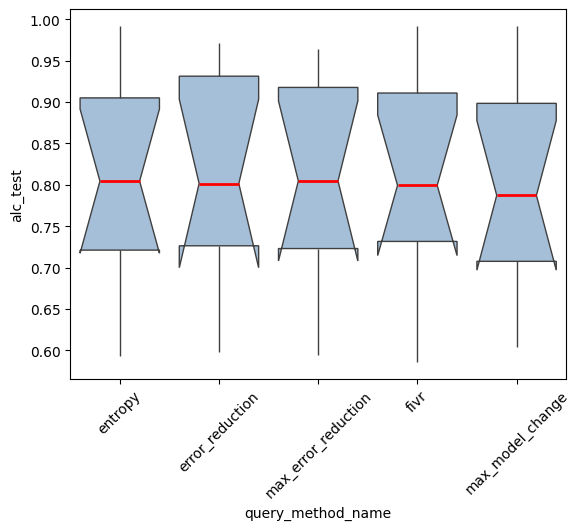

In [15]:
boxplot = sns.boxplot(
    data=mlflow_df, x="query_method_name", y="alc_test",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.3, .5, .7, .5)},
    medianprops={"color": "r", "linewidth": 2},
        order=['entropy', 'error_reduction', 'max_error_reduction','fivr','max_model_change'],
)
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)
plt.show()

In [16]:
means = mlflow_df[mlflow_df.query_method_name!="random"][['query_method_name','alc_ratio']].groupby('query_method_name').mean().reindex(['entropy', 'error_reduction', 'max_error_reduction','fivr','max_model_change'])
means

,alc_ratio
query_method_name,
entropy,1.017058
error_reduction,1.015094
max_error_reduction,1.008772
fivr,1.015859
max_model_change,1.003161


/tmp/ipykernel_126672/1598602178.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)


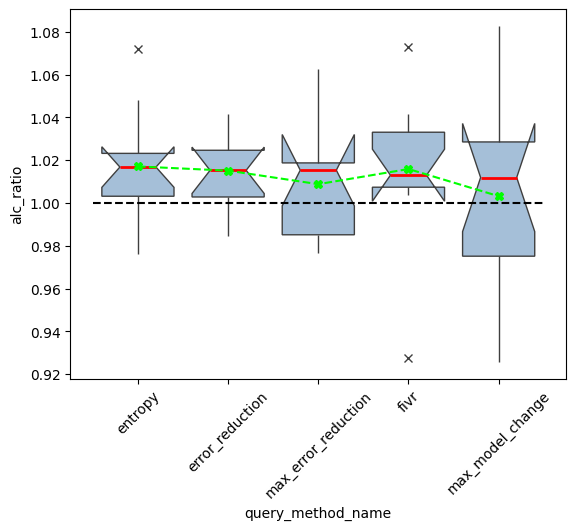

In [17]:
boxplot = sns.boxplot(
    data=mlflow_df[mlflow_df.query_method_name!="random"], x="query_method_name", y="alc_ratio",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.3, .5, .7, .5)},
    medianprops={"color": "r", "linewidth": 2},
    order=['entropy', 'error_reduction', 'max_error_reduction','fivr','max_model_change'],
)


xticks = boxplot.get_xticks()

boxplot.plot([xticks[0]-0.5,xticks[-1]+0.5],[1,1],'k--')
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)
boxplot.plot(xticks,means.values,'X--',color='lime',zorder=5)
plt.show()

# ACC CURVES

In [18]:
os.listdir("results")

['fixed', 'large_paper', 'reproduce', 'reproduce_small']

In [19]:
import os
import os.path as osp
import matplotlib as mpl

dataset = "ionosphere"
folder = "large_paper"
lam_config = "lam_0.01"


result_path = osp.join("results",folder,dataset)

results = {}
data_sizes = {}

for fold in os.listdir(result_path):
    score_path = osp.join(result_path,fold,lam_config)
    scores = np.load(osp.join(score_path,"score_matrix_test.npy"))
    data_size_ = np.load(osp.join(score_path,"data_sizes.npy"))
    results[fold] = scores
    data_sizes[fold] = data_size_

In [20]:
accuracy_baseline = mlflow_df[(mlflow_df.dataset==dataset)].iloc[0].accuracy_baseline

In [21]:
cmap = mpl.colormaps['jet']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(results)))

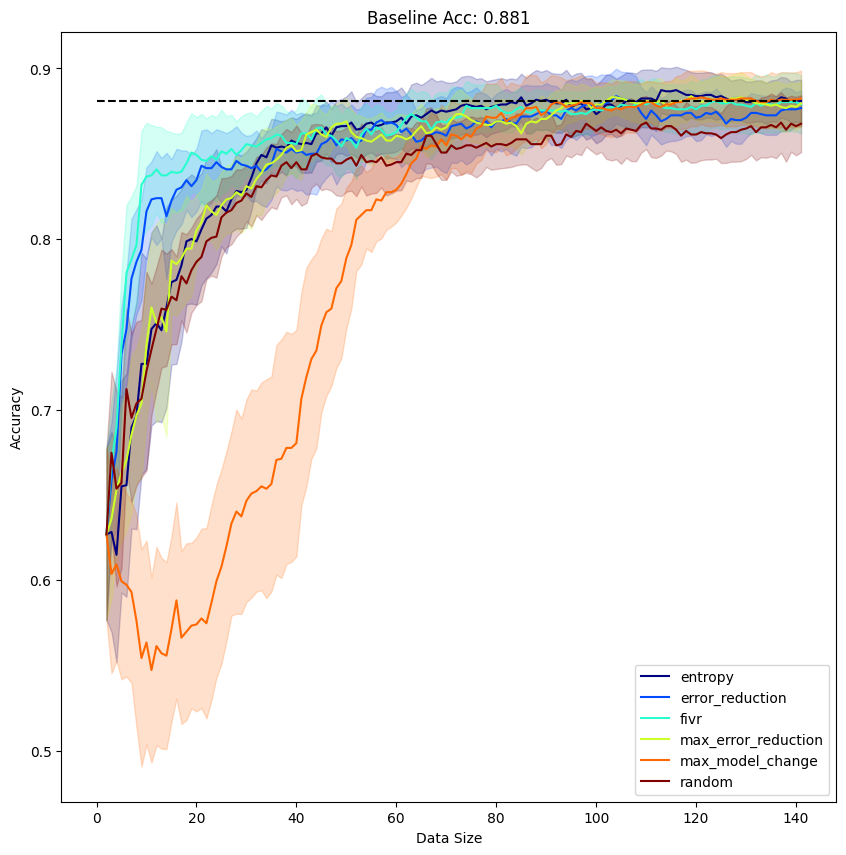

In [22]:
plt.figure(figsize=(10,10))
for i,(fold,val) in enumerate(results.items()):
    # Convert the matrix to a DataFrame
    x = data_sizes[fold]
    x_repeated = np.tile(x,val.shape[0])
    y_flat = val.flatten()
    sns.lineplot(x=x_repeated, y=y_flat, errorbar=('se',2),color=colors[i],label=fold)  # ci='sd' uses standard deviation for confidence intervals

    
#     df = pd.DataFrame(val, columns=[f'Round {i+1}' for i in range(val.shape[-1])])
    
        # Melt the DataFrame to long format for seaborn
#     df_long = df.melt(var_name='Round', value_name='Accuracy')

#     sns.lineplot(data=df_long, x='Round', y='Accuracy', errorbar='se',label=fold,color=colors[i])  # 'sd' gives the standard deviation as confidence interval

plt.plot([0,val.shape[-1]],[accuracy_baseline,accuracy_baseline],'k--')
plt.title("Baseline Acc: {:.3f}".format(accuracy_baseline))
plt.xlabel("Data Size")
plt.ylabel("Accuracy")
plt.legend()

## Accuracy versus time

In [39]:
val_df = mlflow_df.loc[mlflow_df.groupby(['query_method_name','dataset'])['accuracy_baseline'].idxmax()]
val_acc_df = val_df.pivot_table(index='dataset', columns='query_method_name', values='accuracy_test', aggfunc='max')
datasets = list(val_acc_df.dropna(axis=0).index)
methods = list(val_acc_df.dropna(axis=0).columns)


In [40]:
result_path = osp.join("results",folder)

results_acc = {}
results_time = {}
results_alc = {}
results_datasizes = {}

for dataset in datasets:
    for method in methods:
        lam_config = f"lam_0.01"
        score_path = osp.join(result_path,dataset,method,lam_config)
        scores = np.load(osp.join(score_path,"score_matrix_test.npy"))
        times = np.load(osp.join(score_path,"matrix_time.npy"))
        scores_alc = np.load(osp.join(score_path,"alc_matrix_test.npy"))
        datasize = np.load(osp.join(score_path,"data_sizes.npy"))[-1]*2

        results_alc[dataset+method]  = scores_alc
        results_acc[dataset+method] = scores
        results_time[dataset+method] = times
        results_datasizes[dataset+method] = datasize

/tmp/ipykernel_126672/2770495863.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[0].scatter(x=x,y=y,
/tmp/ipykernel_126672/2770495863.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[1].scatter(x=x,y=y,


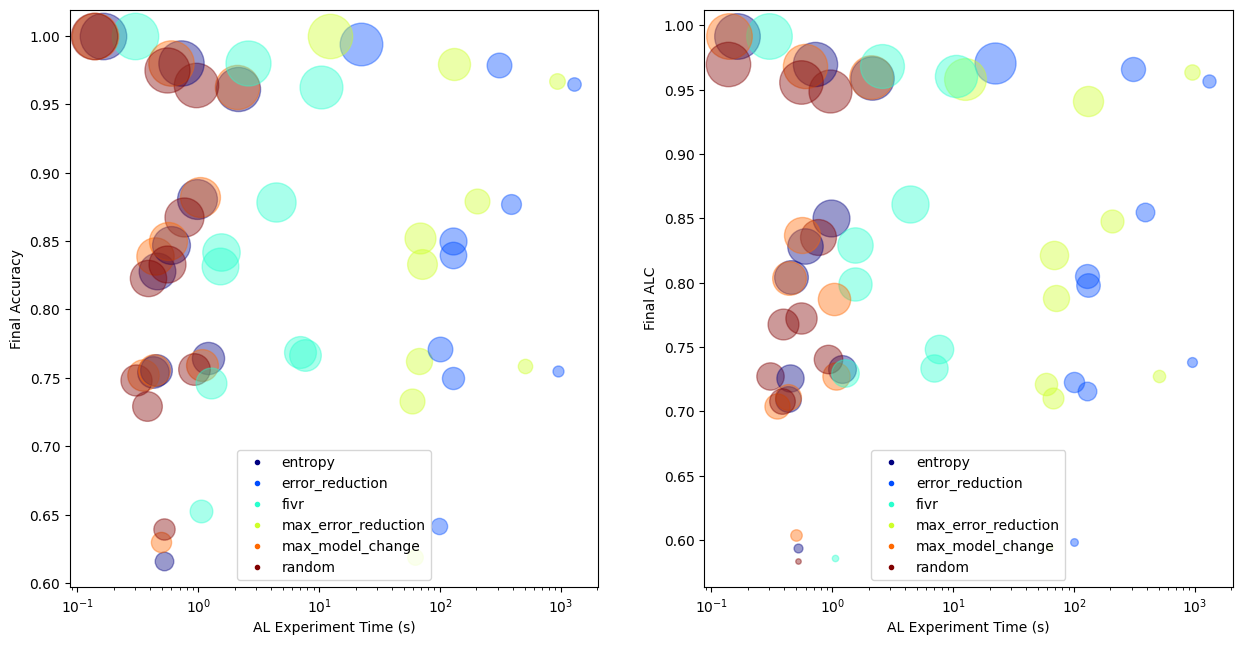

In [41]:
fig,axes = plt.subplots(1,2,figsize=(15,7.5))

xs = []
ys_alc =  []
ys_acc =  []

for dataset in datasets:
    for i,method in enumerate(methods):

        xs.append(results_time[dataset+method].sum(axis=-1).mean())
        ys_alc.append(results_acc[dataset+method][:,-1].ravel().mean())
        ys_acc.append(results_alc[dataset+method].mean())

norm_time = lambda x: (x-min(xs))/(max(xs)-min(xs))

norm_alc = lambda x: (x-min(ys_alc))/(max(ys_alc)-min(ys_alc))
norm_acc = lambda x: (x-min(ys_acc))/(max(ys_acc)-min(ys_acc))

for dataset in datasets:
    for i,method in enumerate(methods):

        x = results_time[dataset+method].sum(axis=-1).mean()
        y = results_acc[dataset+method][:,-1].ravel().mean()

        axes[0].scatter(x=x,y=y,
                        c=colors[i],
                        s=1/(norm_time(x)+0.1)*(norm_acc(y)+0.1)*100,
                        label="_nolabel_",alpha=0.4)
        axes[0].set_xscale("log")

        
        x = results_time[dataset+method].sum(axis=-1).mean()
        y = results_alc[dataset+method].mean()
        axes[1].scatter(x=x,y=y,
                        c=colors[i],
                        s=1/(norm_time(x)+0.1)*(norm_alc(y)+0.1)*100,
                        label="_nolabel_",alpha=0.4)
        axes[1].set_xscale("log")
        
for j in range(2):
    for i,method in enumerate(methods):
        axes[j].plot([],[],
                color=colors[i],marker='.',label=method,linestyle='none')


        # plt.plot([x[0],x[-1]],[accuracy_baseline,accuracy_baseline],'k--')
        axes[j].set_xlabel("AL Experiment Time (s)")
        axes[j].set_ylabel("Final {}".format("Accuracy" if j==0 else "ALC"))
        axes[j].legend()

In [42]:
for dataset in datasets:
    for method in methods:
        if method == "random":
            continue
        lam_config = f"lam_0.01"
        score_path = osp.join(result_path,dataset,method,lam_config)

        results_alc[dataset+method]  = (results_alc[dataset+method]-results_alc[dataset+"random"])/results_alc[dataset+"random"] * 100
        results_acc[dataset+method] = (results_acc[dataset+method] -results_acc[dataset+"random"])/results_acc[dataset+"random"] * 100

In [43]:
for dataset in datasets:
    for method in methods:
        if method == "random":
            del results_alc[dataset+method]
            del results_acc[dataset+method]

/tmp/ipykernel_126672/1982828799.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[0].scatter(x=x,y=y,
/tmp/ipykernel_126672/1982828799.py:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[1].scatter(x=x,y=y,


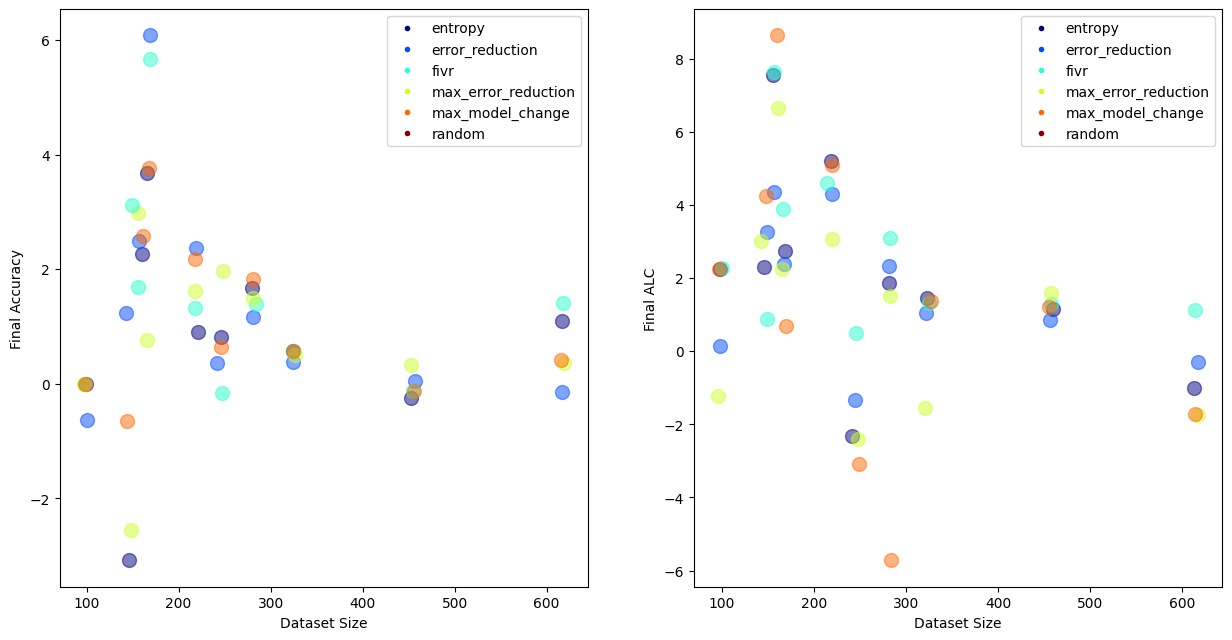

In [44]:
fig,axes = plt.subplots(1,2,figsize=(15,7.5))

xs = []
ys_alc =  []
ys_acc =  []

for dataset in datasets:
    for i,method in enumerate(methods):
        if method == "random":
            continue
        xs.append(results_datasizes[dataset+method])
        ys_alc.append(results_acc[dataset+method][:,-1].ravel().mean())
        ys_acc.append(results_alc[dataset+method].mean())

norm_time = lambda x: (x-min(xs))/(max(xs)-min(xs))

norm_alc = lambda x: (x-min(ys_alc))/(max(ys_alc)-min(ys_alc))
norm_acc = lambda x: (x-min(ys_acc))/(max(ys_acc)-min(ys_acc))

for dataset in datasets:
    for i,method in enumerate(methods):
        if method == "random":
            continue
        x = results_datasizes[dataset+method]+np.random.randn()*2
        y = results_acc[dataset+method][:,-1].ravel().mean()

        axes[0].scatter(x=x,y=y,
                        c=colors[i],
                        s=100,
                        label="_nolabel_",alpha=0.5)

        
        x = results_datasizes[dataset+method]+np.random.randn()*2
        y = results_alc[dataset+method].mean()
        axes[1].scatter(x=x,y=y,
                        c=colors[i],
                        s=100,
                        label="_nolabel_",alpha=0.5)
        
for j in range(2):
    for i,method in enumerate(methods):
        axes[j].plot([],[],
                color=colors[i],marker='.',label=method,linestyle='none')


        # plt.plot([x[0],x[-1]],[accuracy_baseline,accuracy_baseline],'k--')
        axes[j].set_xlabel("Dataset Size")
        axes[j].set_ylabel("Final {}".format("Accuracy" if j==0 else "ALC"))
        axes[j].legend()